# IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.stats.weightstats import DescrStatsW

## Definitions

In [93]:
# Set Seaborn configurations
sns.set_palette('Accent')
sns.set_style('darkgrid')

# standard font for plots
def std_font(ax1, title, xlabel, ylabel):
    ax1.set_title(title, loc='left',fontdict={'fontsize':18}, pad=20)
    ax1.set_xlabel(xlabel, fontdict={'fontsize':12, 'style':'italic'})
    ax1.set_ylabel(ylabel, fontdict={'fontsize':12, 'style':'italic'})
    return None

## Loading Data

In [3]:
df_raw = pd.read_csv('kc_house_data.csv', parse_dates=['date'])

# DATA DESCRIPTION

## Data Preview

In [4]:
df_raw.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


## Data Format and Types

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In this dataset we dont have NA values. So we will skip the step of NA checking and treatment.

## Discriptive Statistics

In [6]:
# numerical attributes
df_raw_num_att = df_raw.select_dtypes(include=['int64', 'float64'])

# getting skew
skew = pd.DataFrame(df_raw_num_att.apply(lambda x: x.skew())).round(2).T
skew.rename(index={0: 'skew'}, inplace=True)

# getting kurtosis
kurtosis = pd.DataFrame(df_raw_num_att.apply(lambda x: x.kurtosis())).round(2).T
kurtosis.rename(index={0: 'kurtosis'}, inplace=True)

# numerical features 
describe = df_raw.describe().round(2)
m = pd.concat([describe, skew, kurtosis], axis=0)
m.iloc[:,1:]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00
mean,540088.14,3.37,2.11,2079.90,15106.97,1.49,0.01,0.23,3.41,7.66,1788.39,291.51,1971.01,84.40,98077.94,47.56,-122.21,1986.55,12768.46
std,367127.20,0.93,0.77,918.44,41420.51,0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,27304.18
min,75000.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,321950.00,3.00,1.75,1427.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,645000.00,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.32,6210.00,871200.00
skew,4.02,1.97,0.51,1.47,13.06,0.62,11.39,3.40,1.03,0.77,1.45,1.58,-0.47,4.55,0.41,-0.49,0.89,1.11,9.51
kurtosis,34.59,49.06,1.28,5.24,285.08,-0.48,127.63,10.89,0.53,1.19,3.40,2.72,-0.66,18.70,-0.85,-0.68,1.05,1.60,150.76


 Now that we have some statistics for our data let's check for possible anomalies or points of attention.
 
 - Price, sqft_above and sqft_basement has a considerable max-min interval, this can indicate possible outliers. So we must be aware of it.
 
 - We detected a house with 33 bedrooms (which is a lot, isnt it?). since the average is 3.37, we are probably facing an error in the data
 
 - We noticed that sqft_lot has a huge kurtosis value and a high skew value. This means that most of the sqft_lot data lives in a narrow range of values wich are probably located in the initial quantiles.
 
 - From the statistics, we can affirm that most of the houses are not waterfront.
 
 - We have the value zero in the yr_renovated feature. This probably means that the house has never been renovated.
 
 - There are some houses with no bedrooms and no bathrooms. Since we don't have a business team to debate this matter, we will consider that these cases are properties that have not yet finished the house. This way they will have sqft_living and sqft_lot to continue building the house.
 

# QUESTIONS & HYPOTESIS

**1.** On average, higher square footage of the land space leads to higher house prices?

**2.** On average, higher square footage of the interior living space leads to higher house prices?

**3.** How the number of bathrooms and bedrooms affects the house prices?

**4.** On average, when is the best time (month or season) to sell and to buy a house?

**5.** Does the neigbhorhood average interior sqft living affects the house price?

**6.** On average, houses with basement are 20% more expensive than those whithout basement.

**7.** On average, 5 condition rated houses are 15% more expensive.

**8.** Waterfront houses are 20% more expensive.

**9.** On average, renovated house are 25% more expensive than not renovated ones.

**10.** For each grade level (construction and design) the house price increases 4%.

**11.** For each view level the house price increases 2%.




# DATAFRAME FILTERING

## Line Filtering

For line filtering, I am assuming that the house with 33 bedrooms is a case of MCAR (missing completely at random). So, the removal of this data will not add bias to our dataset.

In [7]:
# Removing the house with 33 bedrooms
aux2 = df_raw[df_raw['bedrooms'] < 33 ]

# FEATURE ENGINEERING

In [8]:
# Creating feature 'renovated'
aux2.insert(len(aux2.columns), 'renovated', aux2.loc[:,'yr_renovated'].apply(lambda x: 1 if x > 0 else 0))

# Creating feature year_month
aux2.insert(len(aux2.columns), 'year_month', aux2.loc[:,'date'].dt.strftime('%Y-%m'))

# Creating feature year_week
aux2.insert(len(aux2.columns), 'year_week', aux2.loc[:,'date'].dt.strftime('%Y-%U'))

# creating feature sqft_ratio
aux2.insert(len(aux2.columns), 'sqft_ratio', aux2.loc[:,'sqft_living'] / aux2.loc[:,'sqft_living15'])

# EXPLORATORY DATA ANALYSIS

## Univariate Analysis

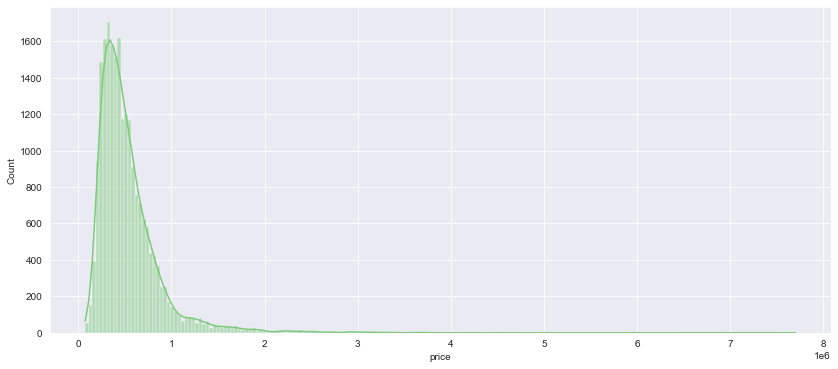

In [9]:
plt.figure( figsize=(14, 6) )
ax = sns.histplot(data = aux2['price'], kde=True, bins=200)


### Response Variable

### Numerical Variable

## Bivariate Analysis

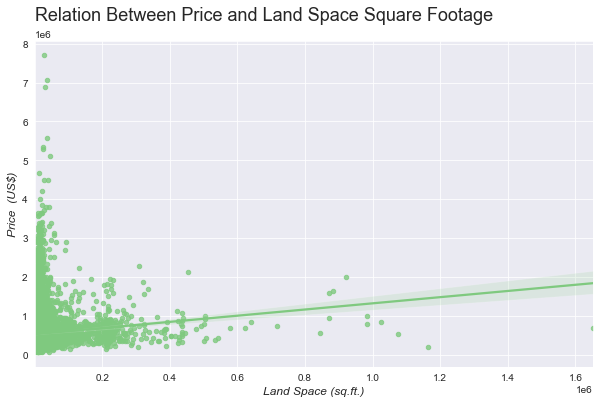

In [132]:
# 1)
# df_sqftlot_price = aux2[['sqft_lot', 'price']].groupby('sqft_lot').mean().reset_index()
plt.figure( figsize=(10, 6))
ax1 = sns.regplot(data=aux2, x='sqft_lot', y='price', scatter_kws={"s": 20})
std_font(ax1, 'Relation Between Price and Land Space Square Footage', 'Land Space (sq.ft.)', 'Price (US$)')
    
ax=ax
# 0.09 correlation

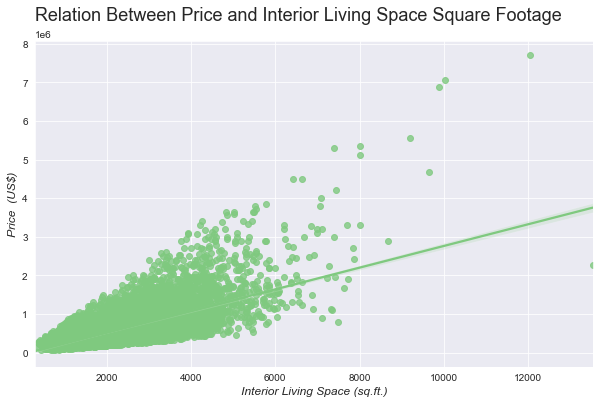

In [133]:
# 2)
# df_sqftliving_price = aux2[['sqft_living', 'price']].groupby('sqft_living').mean().reset_index()
plt.figure( figsize=(10, 6) )
ax1 = sns.regplot(data=aux2, x='sqft_living', y='price')
std_font(ax1, 'Relation Between Price and Interior Living Space Square Footage', 'Interior Living Space (sq.ft.)', 'Price (US$)')
# 0.70 correlation


(-1.0, 7000000.0)

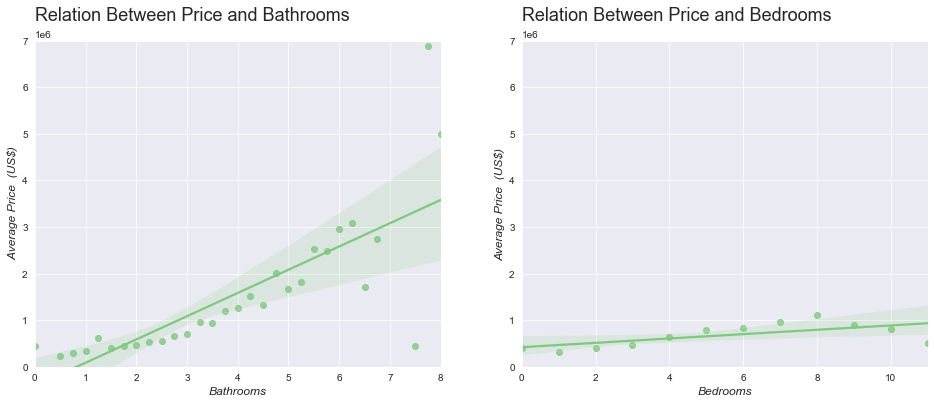

In [182]:
# 3)
bedroom = aux2[['bedrooms','price']].groupby('bedrooms').mean().reset_index().round(2)
bathroom = aux2[['bathrooms','price']].groupby('bathrooms').mean().reset_index().round(2)
# bed_bath
plt.figure(figsize=(16,6))
ax1 = plt.subplot(1,2,1)
plot1 = sns.regplot(data=bathroom, x="bathrooms", y="price")
std_font(plot1, 'Relation Between Price and Bathrooms', 'Bathrooms', ' Average Price (US$)')
plot1.set_ylim(-1,7000000)


ax2 = plt.subplot(1,2,2)
plot2 = sns.regplot(data=bedroom, x="bedrooms", y="price")
std_font(plot2, 'Relation Between Price and Bedrooms', 'Bedrooms', 'Average Price (US$)')
plot2.set_ylim(-1,7000000)


# bedrooms correlation = 0.32
# bathrooms correlation = 0.53

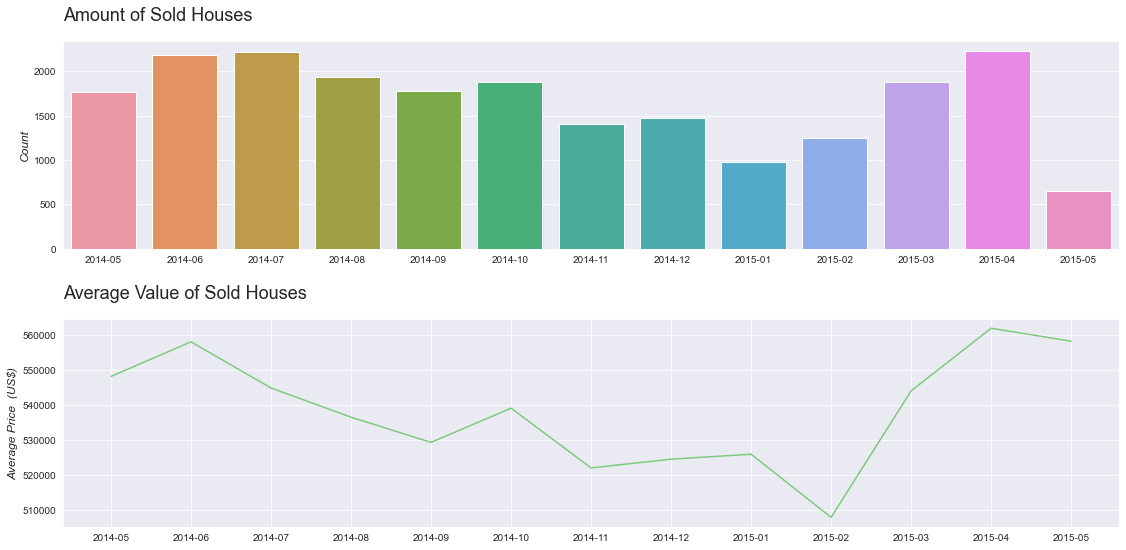

In [183]:
# 4) 
count_year_month = aux2[['year_month','price']].groupby('year_month').count().reset_index()
average_year_month = aux2[['year_month','price']].groupby('year_month').mean().reset_index()

plt.figure(figsize=(16,8), tight_layout={'pad':2.0})
ax1 = plt.subplot(2,1,1)
ax = sns.barplot(data=count_year_month, x='year_month', y='price')
std_font(ax, 'Amount of Sold Houses', '', 'Count')

ax2 = plt.subplot(2,1,2)
sns.lineplot(data=average_year_month, x='year_month', y='price')
std_font(ax2, 'Average Value of Sold Houses', '', 'Average Price (US$)')

# prices get low on winter
# 2015-05 less selled houses but more income

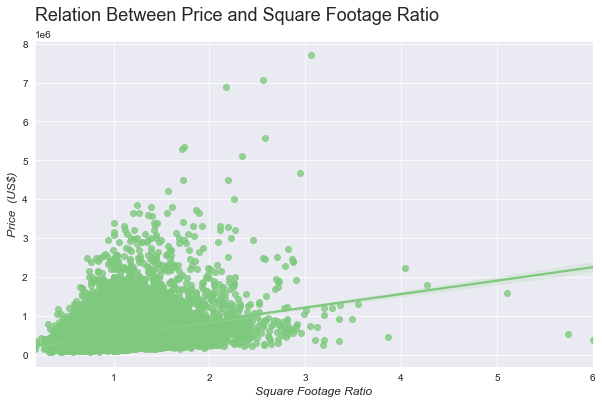

In [157]:
# 5)
plt.figure( figsize=(10, 6) )
ax1 = sns.regplot(data=aux2, x='sqft_ratio', y='price')
std_font(ax1, 'Relation Between Price and Square Footage Ratio', 'Square Footage Ratio', 'Price (US$)')
# sqft_ratio = 0.30 correlation

In [156]:
# 6)
avg_with_basement = aux2.query('sqft_basement > 0')['price'].mean()
avg_without_basement = aux2.query('sqft_basement == 0')['price'].mean()
display(round(avg_with_basement / avg_without_basement,2))

with_basement = aux2.query('sqft_basement > 0')[['price', 'sqft_basement']]
with_basement.corr()

1.28

,price,sqft_basement
price,1.000000,0.407314
sqft_basement,0.407314,1.000000


1.15

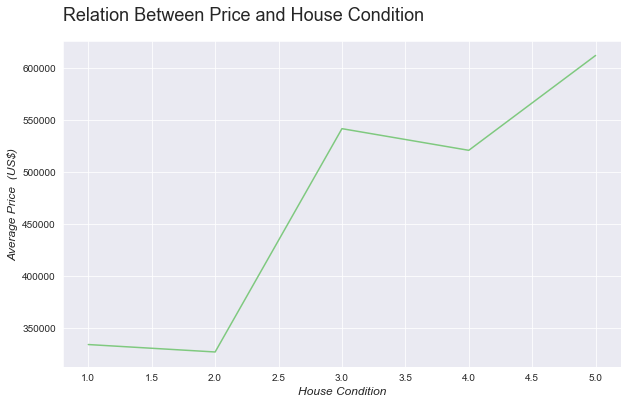

In [184]:
# 7)

avg_conds = aux2.query('condition < 5')['price'].mean()
avg_cond_5 = aux2.query('condition == 5')['price'].mean()
display(round(avg_cond_5 / avg_conds, 2))

conditions = aux2[['price', 'condition']].groupby('condition').mean().reset_index().round(2)
plt.figure( figsize=(10, 6) )
ax1 = sns.lineplot(data=conditions, x='condition', y='price')
std_font(ax1, 'Relation Between Price and House Condition', 'House Condition', 'Average Price (US$)')

In [212]:
condition_1 = aux2.query('condition == 1')['price']
condition_2 = aux2.query('condition == 2')['price']
condition_3 = aux2.query('condition == 3')['price']
condition_4 = aux2.query('condition == 4')['price']

test_condition_1 = DescrStatsW(condition_1)
test_condition_2 = DescrStatsW(condition_2)
test_condition_3 = DescrStatsW(condition_3)
test_condition_4 = DescrStatsW(condition_4)

test1 = test_condition_1.get_compare(test_condition_2)
display(test1.ztest_ind(alternative='two-sided'))

test2 = test_condition_3.get_compare(test_condition_4)
display(test2.ztest_ind(alternative='larger'))

(0.1448335160391589, 0.8848423192446704)

(3.6479391302865967, 0.0001321761220871356)

In [160]:
# 8)
price_waterfront = aux2[['price', 'waterfront']].groupby('waterfront').mean().round(2)

round(price_waterfront.iloc[1,0] / price_waterfront.iloc[0,0], 2)

3.13

In [162]:
# 9)
renovated = aux2[['price', 'renovated']].groupby('renovated').mean()
round(renovated.iloc[1,0] / renovated.iloc[0,0], 2)

1.43

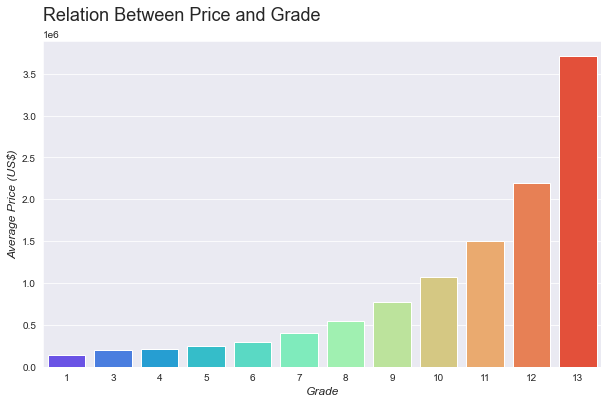

In [185]:
# 10) 
grade_price = aux2[['price','grade']].groupby('grade').mean().reset_index().round(2)
plt.figure( figsize=(10, 6) )
ax1 = sns.barplot(data=grade_price, x='grade', y='price', palette='rainbow')
std_font(ax1, 'Relation Between Price and Grade', 'Grade', 'Average Price (US$)')

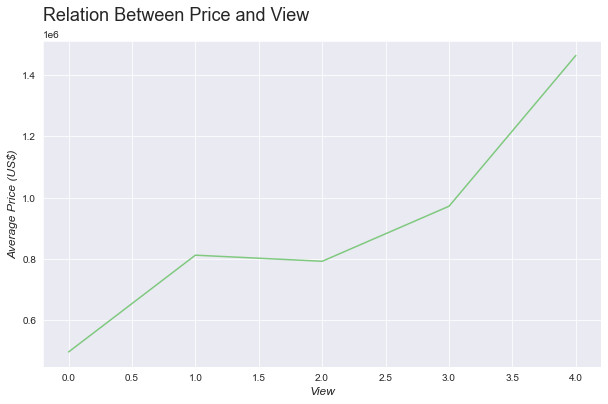

In [191]:
# 11)
view_price = aux2[['price','view']].groupby('view').mean().reset_index().round(2)
plt.figure( figsize=(10, 6) )
ax1 = sns.lineplot(data=view_price, x='view', y='price')
std_font(ax1, 'Relation Between Price and View', 'View', 'Average Price (US$)')

In [208]:
# Hypotesis Test
view_1 = aux2.query('view == 1')['price']
view_2 = aux2.query('view == 2')['price']
test_view_1 = DescrStatsW(view_1)
test_view_2 = DescrStatsW(view_2)
test = test_view_1.get_compare(test_view_2)
test.ztest_ind(alternative='two-sided')

(0.6120949454420749, 0.5404749415499239)

## Multivariate Analysis

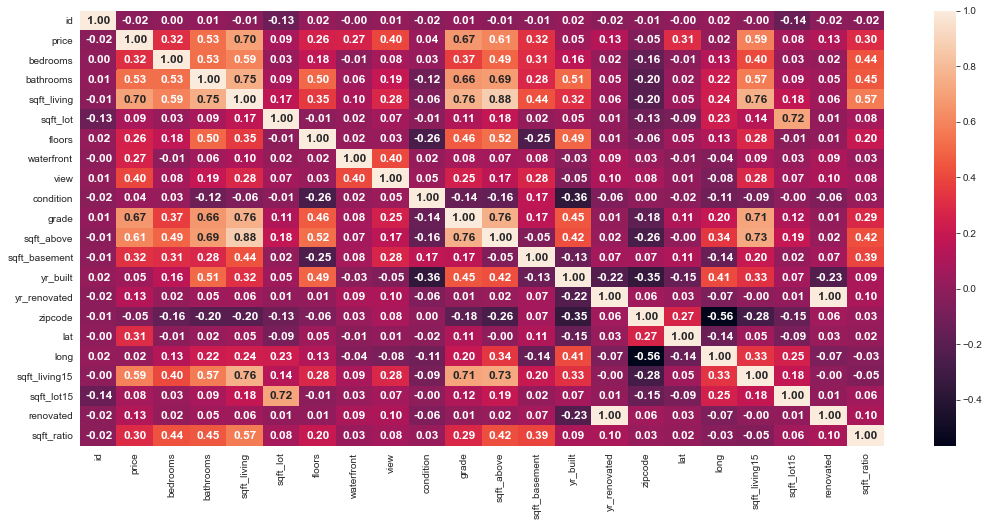

In [226]:
correlation = aux2.corr(method='pearson')
plt.figure( figsize=(18, 8) )
sns.heatmap(data=correlation, annot=True, fmt='.2f', annot_kws={'fontsize':12, 'fontweight':'bold'})
ax=ax

# OVERVIEW AND NEXT STEPS

- Gather more information about house sales in other years in order to get time based insights

- Gather information about the costs to increase the house view, construction of bathrooms, house renovation, construction of basement.